<a href="https://colab.research.google.com/github/Nick-Azzarano/Machine-Learning-Practice/blob/main/Spring2025/Homeworks/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nick Azzarano
<br/>
CSCI 335
<br/>
Anton Selitskiy
<br/>
March 3, 2025

#Homework 6
Part 1 (3pt): Softmax

Part 2 (8pt): Bayes: MAP estimator for continuous data

Part 3 (9pt): Naive Bayes: Bayesian spam filter (discrete date)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#Part 1
When computing the output probabilities from margins $x_1,\ x_2,\ \ldots,\ x_C$, often (incorrectly) called *logits*, the exponential terms may be very large or very small. This can cause numerical or overflow errors (try `np.exp(1000)`).

Check that the following formula is correct for an arbitrary $A$:

$$
Softmax_i = \frac{e^{x_i}}{\sum\limits_{c=1}^{C} e^{x_c}} = \frac{e^{x_i-A}}{\sum\limits_{c=1}^{C} e^{x_c-A}}.
$$

A suitable choice for this fixed value $A$ is
$$
A = \underset{c}{\max} x_c.
$$

##Q1 (3pt) Write a function `compute_probabilities` that computes Softmax.

In [3]:
def compute_probabilities(X):
    """
    Computes Softmax, for each vector X[i, :].

    Args:
        X - (n, C) NumPy array (n datapoints each with C features)
    Returns:
        H - (n, C) NumPy array, where each row H[i,:] = Softmax(X[i,:])
    """
    #YOUR CODE HERE
    # Step 1: Subtract the maximum value of each row from each element in the row.
    # This is done to avoid numerical overflow when computing the exponential.
    X_max = np.max(X, axis=1, keepdims=True)
    X_shifted = X - X_max

    # Step 2: Compute the exponential of each element in the shifted array.
    exp_X_shifted = np.exp(X_shifted)

    # Step 3: Compute the sum of the exponential values in each row.
    sum_exp_X_shifted = np.sum(exp_X_shifted, axis=1, keepdims=True)

    # Step 4: Divide the exponential values in each row by the sum of the exponential values in the row.
    # This gives the Softmax probabilities for each element in the row.
    H = exp_X_shifted / sum_exp_X_shifted

    return H

In [4]:
#Test yourself
from scipy.special import softmax
M = np.random.randint(-1000, 1000, size=(30,20))
assert np.allclose(compute_probabilities(M), softmax(M, axis=1))

#Part 2
In this Question you will work with dataset from Ch.2 in *Classification, Parameter Estimation and State
Estimation: An Engineering Approach Using MATLAB* by
R. Duin, F. van der Heijden, D. de Ridder, and D. M.
J. Tax https://go.exlibris.link/Y6BQ8cJ5

In your solution, you should get similar desision boundaries as in the texbook:

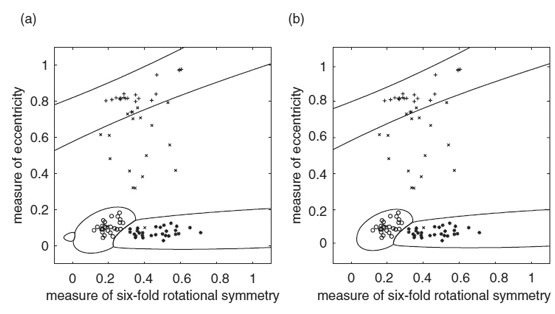

In [5]:
#data = pd.read_csv('data_bnrs.csv', header=None)
data = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2023_fall/data_bnrs.csv', header=None)

In [6]:
data.head()
# 2 columns of features, and 1 column of label

,0,1,2
0,0.35029,0.79978,1
1,0.60302,0.97778,1
2,0.32696,0.74125,1
3,0.35015,0.83668,1
4,0.46741,0.94682,1


In [7]:
X = data.iloc[:,:-1].values
y = data.iloc[:,-1].values

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

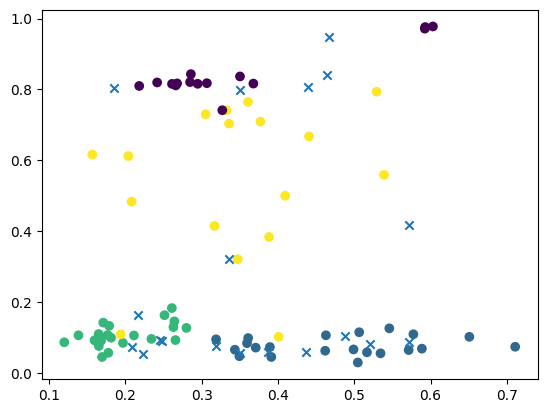

In [9]:
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.scatter(X_test[:,0], X_test[:,1], marker='x')

From the conditional probability formula, we know that
$$
p(y=c|x) = \frac{p(x, y=c)}{p(x)} = \frac{p(x|y=c)p(y=c)}{p(x)}, \quad c=1,2,3,4.
$$

Because the denominator doesn't depend on $c,$
$$
a(x) = \underset{c}{argmax}\ p(y=c|x) = \underset{c}{argmax}\ p(x|y=c)p(y=c).
$$

We will assume that conditional distribution $p(x|y=c)\sim N(\mu_c,\Sigma_c)$ you can use `multivariate_normal` from `scipy.stats` to calculate this value for the entier matix $X$ with datapoints in rows $X[i,:]$ as follows: `multivariate_normal(X, mean=, cov=)`.

For the Cost function, you can use the following decision rule:
$$
a(x) = argmin\ \text{Cost_Matrix}\cdot \begin{bmatrix}p(y=1|x)\\ p(y=2|x) \\ p(y=3|x)\\ p(y=4|x)\end{bmatrix} = argmin\ \text{Cost_Matrix}\cdot \begin{bmatrix}p(x|y=1)p(y=1)\\ p(x|y=2)p(y=2) \\ p(x|y=3)p(y=3)\\ p(x|y=4)p(y=4)\end{bmatrix}.
$$

##Q2 (8pt) Write the class `UserMAP` for maximum a posteriori estimator

In [10]:
from scipy.stats import multivariate_normal

In [11]:
class UserMAP():
    def __init__(self, cost=False):
        self.cost = cost

    def fit(self, X, y):
      """
      Calculate mean values and covariance matrices for each class
      Calculate class distribution p(y)
      Store them as self. variables
      """
      # pass
      # YOUR CODE HERE
      self.m1 = X[y==1,:].mean(axis=0)
      self.C1 = np.cov(X[y==1,:].T)
      self.m2 = X[y==2,:].mean(axis=0)
      self.C2 = np.cov(X[y==2,:].T)
      self.m3 = X[y==3,:].mean(axis=0)
      self.C3 = np.cov(X[y==3,:].T)
      self.m4 = X[y==4,:].mean(axis=0)
      self.C4 = np.cov(X[y==4,:].T)
      unique_elements, counts_elements = np.unique(y, return_counts=True)
      self.p1, self.p2, self.p3, self.p4 = counts_elements/len(y)
      return self

    def posterior(self, X, return_probs=False):
      """
      Calculate posterior pobabilities and return argmax
      """
      # pass
      # YOUR CODE HERE
      #YOUR CODE HERE
      # this should be very similar to the in class problems 12, but not exactly the same.
      probs = np.vstack([
            multivariate_normal.pdf(X, mean=self.m1, cov=self.C1) * self.p1,
            multivariate_normal.pdf(X, mean=self.m2, cov=self.C2) * self.p2,
            multivariate_normal.pdf(X, mean=self.m3, cov=self.C3) * self.p3,
            multivariate_normal.pdf(X, mean=self.m4, cov=self.C4) * self.p4
        ]).T
      if return_probs:
        return probs
      else:
        return np.argmax(probs, axis=1) + 1  # Add 1 to match class labels {1,2,3,4}




    def posterior_cost(self, X):
      """
      Given the cost matrix and posterior probabilities, predict the class
      """
      cost_matrix = np.array([
        [ -0.20, 0.07, 0.07, 0.07 ],
        [  0.07,-0.15, 0.07, 0.07 ],
        [  0.07, 0.07,-0.05, 0.07 ],
        [  0.03, 0.03, 0.03, 0.03 ]])
      # pass
      #YOUR CODE HERE
      # this should ALSO be very similar to the in class problems 12, but not exactly the same.
      posterior_probs = self.posterior(X, return_probs=True)  # Shape: (num_samples, 4)
      # Compute expected cost for each class
      expected_costs = np.dot(posterior_probs, cost_matrix)  # Shape: (num_samples, 4)
      # Choose the class with the **minimum** expected cost
      return np.argmin(expected_costs, axis=1) + 1  # Add 1 to match class labels {1,2,3,4}


    def predict(self, X):
      if self.cost == True:
        return self.posterior_cost(X)
      return self.posterior(X)

In [12]:
from mlxtend.plotting import plot_decision_regions

In [13]:
clf = UserMAP()

In [14]:
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/mlxtend/plotting/decision_regions.py:346: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


<Axes: >

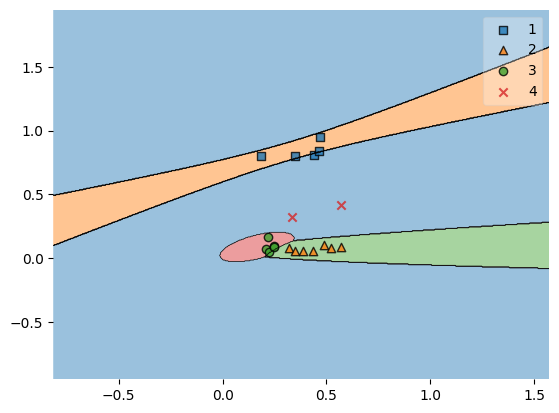

In [15]:
plot_decision_regions(X_test,y_test,clf)

In [16]:
clf_cost = UserMAP(cost=True)

In [17]:
clf_cost.fit(X_train, y_train)

<Axes: >

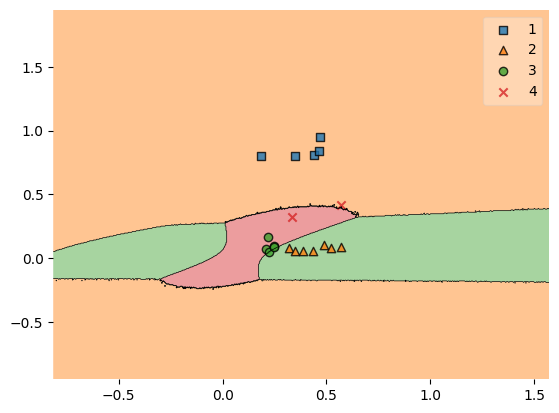

In [18]:
plot_decision_regions(X_test,y_test,clf_cost)

# Part 3
In this Question, you will apply Naive Bayes classifier to build a spam filter. Use dataset from https://www.kaggle.com/datasets/venky73/spam-mails-dataset?select=spam_ham_dataset.csv  It's *Enron email dataset,* a large collection of emails from the Enron Corporation.

In [23]:
!unzip spam_ham_dataset.csv.zip

Archive:  spam_ham_dataset.csv.zip
  inflating: spam_ham_dataset.csv    


In [24]:
import pandas as pd
data = pd.read_csv('spam_ham_dataset.csv')

texts = data['text'].values
target = data['label_num'].values
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [25]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

### Preprocessing and tokenization

### Solving it: bag of words

![img](http://www.novuslight.com/uploads/n/BagofWords.jpg)

Apply `CountVectorizer()` to the training data.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
vec = CountVectorizer()

In [28]:
X_train_bow = vec.fit_transform(texts_train).toarray()
X_test_bow = vec.transform(texts_test).toarray()

In [ ]:
# WE WROTE THIS LINE IN CLASS
# (w + delta) / (total + delta * V)

Now you have the counts of the words from the bag of words in each e-mail.

__Naive bayes:__ perhaps the simplest model that can solve your problem is the so called Naive Bayes Classifier.
Its a simple probabilistic model that assumes the independence of input features and computes the counting probabilities.

If you don't remember the math behind Naive Bayes, read https://scikit-learn.org/stable/modules/naive_bayes.html to help refresh your memory. Done? Good! Now let's implement that :)

For every word we will calculate its frequency in spam and in ham, it will be $p(word|y=0)$ and $p(word|y=1)$. To avoid devisions by zero instead of the formula
$$
p(word|y) =\frac{\#word \text{ in class y}}{\text{total # words in class } y}
$$
use
$$
p(word|y) =\frac{\delta+\#word \text{ in class y}}{\delta\cdot\text{vocabulary length} + \text{total # words in class } y}
$$

##Q3 (9pt) Write the class for Naive Bayes

In [29]:
delta = 1.0
class BinaryNaiveBayes:
#     delta = 1.0  # add this to all word counts to smoothe probabilities

    def fit(self, X, y):
        """
        Fit a NaiveBayes classifier for two classes
        :param X: [batch_size, vocab_size] of bag-of-words features
        :param y: [batch_size] of binary targets {0, 1}
        """
        # first, compute marginal probabilities of every class, p(y=c) for c = 0,1
        # self.p_y = #(<YOUR CODE: probability of y=0 and of y=1 in this order>)
        self.p_y = np.array([np.mean(y == 0), np.mean(y == 1)])

        # count occurences of each word in texts with label 1 and label 0 separately
        # word_counts_positive = #<YOUR CODE HERE>
        # word_counts_negative = #<YOUR CODE HERE>
        # ^-- both must be vectors of shape [vocab_size].
        word_counts_positive = np.sum(X[y == 1], axis=0)
        word_counts_negative = np.sum(X[y == 0], axis=0)

        # finally, lets use those counts to estimate p(x | y = c) for c = 0, 1
        # self.p_x_given_positive = #<...>

        # self.p_x_given_negative = #<...>
        # both must be of shape [vocab_size]; and don't forget to add self.delta!
        #<YOUR CODE HERE>
        self.p_x_given_positive = (delta + word_counts_positive) / (delta * X.shape[1] + np.sum(word_counts_positive))
        self.p_x_given_negative = (delta + word_counts_negative) / (delta * X.shape[1] + np.sum(word_counts_negative))

        return self

    def predict_scores(self, X):
        """
        :param X: [batch_size, vocab_size] of bag-of-words features
        :returns: a matrix of scores [batch_size, k] of scores for k-th class
        """
        # compute scores for positive and negative classes separately.
        # these scores should be proportional to log-probabilities of the respective target {0, 1}
        # note: if you apply logarithm to p_x_given_*, the total log-probability can be written
        # as a dot-prodcut with X

        score_negative = X.dot(np.log(self.p_x_given_negative)) + np.log(self.p_y[0])
        # YOUR CODE HERE ??? not sure. I think it's already done
        score_positive = X.dot(np.log(self.p_x_given_positive)) + np.log(self.p_y[1])
        # YOUR CODE HERE ??? not sure. I think it's already done
        return np.stack([score_negative, score_positive], axis=-1)

    def predict(self, X):
        return self.predict_scores(X).argmax(axis=-1)

In [30]:
naive_model = BinaryNaiveBayes().fit(X_train_bow, y_train)

In [31]:
assert naive_model.p_y.shape == (2,) and naive_model.p_y.sum() == 1 and naive_model.p_y[0] > naive_model.p_y[1]
assert naive_model.p_x_given_positive.shape == naive_model.p_x_given_negative.shape == X_train_bow.shape[1:]
assert np.allclose(naive_model.p_x_given_positive.sum(), 1.0)
assert np.allclose(naive_model.p_x_given_negative.sum(), 1.0)
assert naive_model.p_x_given_negative.min() > 0, "did you forget to add delta?"

Model accuracy: 0.971
Well done!


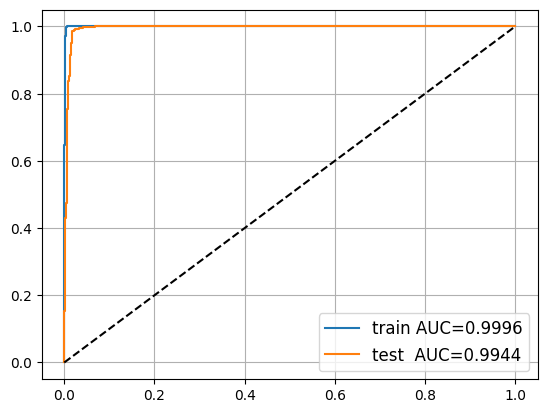

In [32]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, naive_model),
    ('test ', X_test_bow, y_test, naive_model)
]:
    proba = model.predict_scores(X)[:, 1] - model.predict_scores(X)[:, 0]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(naive_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.75, "Accuracy too low. There's likely a mistake in the code."
print("Well done!")

Okay, it definitely learned *something*. Now let's figure out what exactly it learned. The simplest way to do that is by highlighting which words have a greatest ratio of positive to negative probability or vice versa. (The log of that fraction is called *logit.*) Here are top-25 words that have the __highest__ ratio of ${p(x_i | y=0)} \over {p(x_i | y=1)}$.

In [33]:
bow_vocabulary = vec.get_feature_names_out()

In [34]:
probability_ratio = 1/(naive_model.p_x_given_positive/naive_model.p_x_given_negative)
top_negative_words = bow_vocabulary[np.argsort(probability_ratio)[:25]]
assert len(top_negative_words) == 25 and [isinstance(w, str) for w in top_negative_words]

for i, word in enumerate(top_negative_words):
    print(f"#{i}\t{word.rjust(10, ' ')}\t(ratio={probability_ratio[list(bow_vocabulary).index(word)]})")

#0	      nbsp	(ratio=0.0018332767128025555)
#1	     pills	(ratio=0.0027203460899650825)
#2	      2004	(ratio=0.0029664075453388087)
#3	      font	(ratio=0.0035348209672001365)
#4	 computron	(ratio=0.003988615550827182)
#5	        br	(ratio=0.00454088539632633)
#6	        xp	(ratio=0.005676106745407913)
#7	    viagra	(ratio=0.005676106745407913)
#8	    cialis	(ratio=0.006785231051981872)
#9	        td	(ratio=0.006944883547322622)
#10	      soft	(ratio=0.0074723430572458584)
#11	   hotlist	(ratio=0.007977231101654363)
#12	    moopid	(ratio=0.007977231101654363)
#13	     width	(ratio=0.008555291326411927)
#14	      meds	(ratio=0.008681104434153278)
#15	      href	(ratio=0.008810673157051089)
#16	       pro	(ratio=0.008944168204885196)
#17	        mx	(ratio=0.00908177079265266)
#18	  paliourg	(ratio=0.009370080976546395)
#19	      pain	(ratio=0.01017784657797281)
#20	        oo	(ratio=0.010356405289867069)
#21	     adobe	(ratio=0.010541341098614695)
#22	 photoshop	(ratio=0.0105413410986146

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

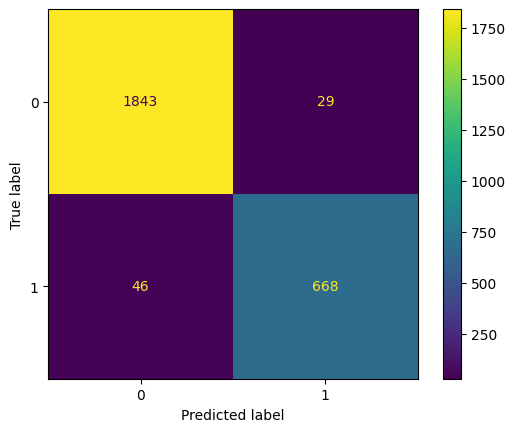

In [36]:
ConfusionMatrixDisplay.from_predictions(y_test, naive_model.predict(X_test_bow))

Now, let's do it with the built-in function and compare results

In [37]:
from sklearn.naive_bayes import MultinomialNB

In [38]:
#<YOUR CODE HERE - train a built-in Naive Bayes>
model = MultinomialNB()
model.fit(X_train_bow, y_train)

MultinomialNB()

In [39]:
np.mean(y_test==model.predict(X_test_bow))

np.float64(0.9709976798143851)

Now lets try something less prehistoric: __Logistic Regression__. It turns out, if you're using silicon instead of an abacus, you can find model weights by optimizing the log-probability of the answer. Though, of course, you don't even need to write it by hand anymore. Let's sklearn it!

You can play with parameter $C=$ in LogisticRegression, it plays similar role as in SVM allowing slightly negative margins.

In [46]:
from sklearn.linear_model import LogisticRegression
#<YOUR CODE HERE - train a logistic regression>
bow_model = LogisticRegression(C=0.75)
bow_model.fit(X_train_bow, y_train)

LogisticRegression(C=0.75)

Model accuracy: 0.969
Well done!


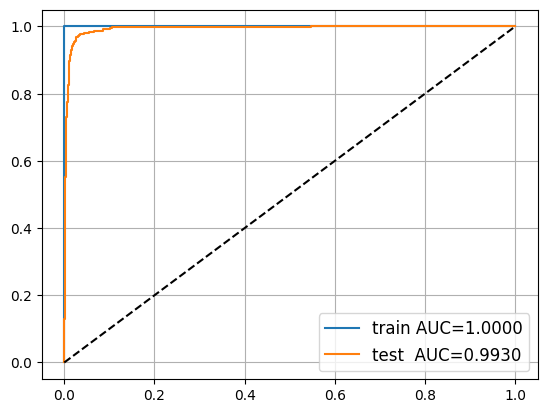

In [47]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

test_accuracy = np.mean(bow_model.predict(X_test_bow) == y_test)
print(f"Model accuracy: {test_accuracy:.3f}")
assert test_accuracy > 0.77, "Hint: tune the parameter C to improve performance"
print("Well done!")

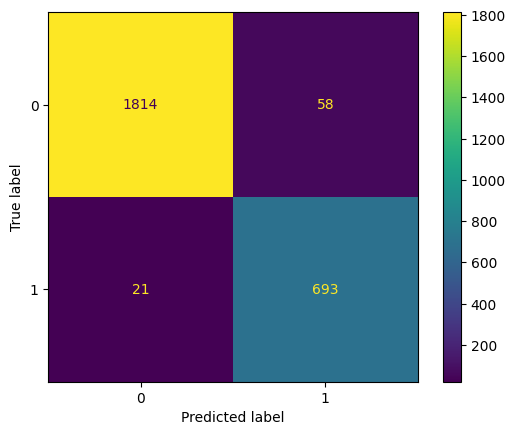

In [48]:
ConfusionMatrixDisplay.from_predictions(y_test, bow_model.predict(X_test_bow))

Finally, you can play with threshold to reduce the False Positive predictions, as you did in HW5.


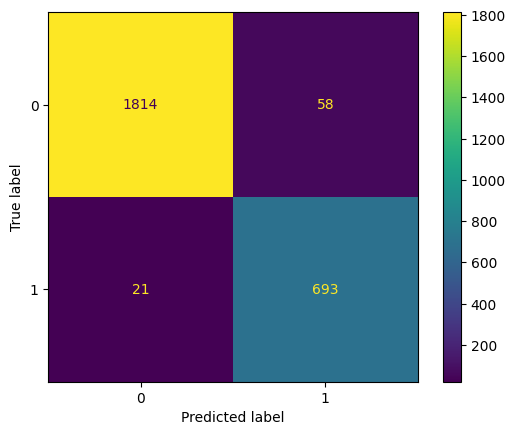

In [57]:
ConfusionMatrixDisplay.from_predictions(y_test, bow_model.predict(X_test_bow) >= 0.1)